In [1]:
import os
import sys
import json
import time
import pickle
import gspread
import numpy as np
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from scipy import integrate, signal, stats, fftpack
import pingouin as pg

## The following is needed to export text correctly for Illustrator ##
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import (
    get_stim_events,
    get_evoked_traces,
    get_evoked_firing_rates,
    find_nearest_ind
)

In [4]:
%matplotlib notebook

In [5]:
plt.rcParams.update({'font.size': 12})

Load Zap_Zip-log_exp to get metadata for experiments

In [6]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
zzmetadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

Define areas of interest to plot population activity

In [7]:
areas_of_interest = {
    'MO': [
        'MOp1', 'MOp2/3', 'MOp5', 'MOp6a', 'MOp6b',
        'MOs1', 'MOs2/3', 'MOs5', 'MOs6a', 'MOs6b'
    ],
    'ACA': [
        'ACAd1', 'ACAd2/3', 'ACAd5', 'ACAd6a', 'ACAd6b',
        'ACAv1', 'ACAv2/3', 'ACAv5', 'ACAv6a', 'ACAv6b'
    ],
    'SS': [
        'SSp-bfd1', 'SSp-bfd2/3', 'SSp-bfd4', 'SSp-bfd5', 'SSp-bfd6a', 'SSp-bfd6b',
        'SSp-ll1', 'SSp-ll2/3', 'SSp-ll4', 'SSp-ll5', 'SSp-ll6a', 'SSp-ll6b',
        'SSp-tr1', 'SSp-tr2/3', 'SSp-tr4', 'SSp-tr5', 'SSp-tr6a', 'SSp-tr6b'
    ],
    'VIS': [
        'VISp1', 'VISp2/3', 'VISp4', 'VISp5', 'VISp6a', 'VISp6b',
        'VISam1', 'VISam2/3', 'VISam4', 'VISam5', 'VISam6a', 'VISam6b',
        'VISpm1', 'VISpm2/3', 'VISpm4', 'VISpm5', 'VISpm6a', 'VISpm6b',
        'VISrl1', 'VISrl2/3', 'VISrl4', 'VISrl5', 'VISrl6a', 'VISrl6b',
    ],
    'MO-TH': [
        'AV', 'CL', 'MD', 'PO', 'RT', 'VAL', 'VPL', 'VPM', 'VM'
    ],
}

In [8]:
area_colors = {
    'MO': (31/255, 157/255, 90/255), # [31, 157, 90] 'blue'
    'ACA': (64/255, 166/255, 102/255), # [64, 166, 102] 'deepskyblue'
    'SS': (24/255, 128/255, 100/255), # [24, 128, 100] 'blueviolet'
    'VIS': (8/255, 133/255, 140/255), # [8, 133, 140] 'green'
    'MO-TH': (255/255, 112/255, 128/255), # [255, 112, 128] 'steelblue'
#     'VIS-TH': 'olivedrab'
}

In [9]:
# state_colors = {
#     'awake': (120/255, 156/255, 74/255),
#     'anesthetized': (130/255, 122/255, 163/255),
#     'recovery': (93/255, 167/255, 229/255)
# }
stcolors = {
    'resting': 'royalblue',
    'running': 'seagreen',
    'anesthetized': 'indianred',
}
stshapes = {
    'resting': 'o',
    'running': 's',
    'anesthetized': '^',
}

#### Functions

In [10]:
def get_stim_event_inds(stim_table, stim_type, stim_param, sweep, trials='stationary'):
    if trials == 'resting':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == True)
        ].index.values
    elif trials == 'running':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == False)
        ].index.values
    else:
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True)
        ].index.values

In [11]:
def get_zFR(trig_FR, FRtime):
    
    trig_Z = np.zeros_like(trig_FR) * np.nan # try NaNs, it works
    baseline_avg = np.mean(trig_FR[FRtime < 0, :], axis=0)
    baseline_std = np.std(trig_FR[FRtime < 0, :], axis=0)
    nonzero_inds = np.nonzero(baseline_std)[0]
    trig_Z[:, nonzero_inds] = (trig_FR[:, nonzero_inds] - baseline_avg[None, nonzero_inds]) / baseline_std[None, nonzero_inds]
    
    return trig_Z

## Load subjects from file

In [12]:
with open(r'C:\Users\lesliec\OneDrive - Allen Institute\data\all_iso_subjects_wPROBES.json') as subjects_file:
    multi_sub_dict = json.load(subjects_file)

In [13]:
for group, group_subs in multi_sub_dict.items():
    print(group)
    print('')
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        mdata['exp'] = EEGexp(mdata['data_loc'], preprocess=False, make_stim_csv=False)
    print('')

MOs_superficial

 575102
Experiment type: electrical and sensory stimulation
 571619
Experiment type: electrical stimulation

MOs_deep

 546655
Experiment type: electrical and sensory stimulation
 551399
Experiment type: electrical stimulation
 551397
Experiment type: electrical and sensory stimulation
 569062
Experiment type: electrical and sensory stimulation
 569068
Experiment type: electrical and sensory stimulation
 569069
Experiment type: electrical and sensory stimulation
 569064
Experiment type: electrical and sensory stimulation
 569073
Experiment type: electrical and sensory stimulation
 571619
Experiment type: electrical stimulation

SSp_superficial

 571620
Experiment type: electrical and sensory stimulation
 586466
Experiment type: electrical and sensory stimulation
 590479
Experiment type: electrical stimulation
 590480
Experiment type: electrical and sensory stimulation
 599017
Experiment type: electrical and sensory stimulation

SSp_deep

 569073
Experiment type: electr

In [14]:
plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\manuscript_figs'

## All subjects

This figure will include example EEG+units for resting/running/iso and some analysis of the units (baseline firing rate, timing of activation, and burst probability). This code does not yet force the number of trials to be the same across states within a subject. May include a superficial example in supplementary?

In [15]:
## Parameters ##
ctx_regions = ['MO', 'ACA', 'SS', 'VIS']
current_levels = ['low', 'medium', 'high']
test_states = ['awake', 'anesthetized']
all_states = ['resting', 'running', 'anesthetized']
apply_car = True
zlim = 3

time_bin = 0.0025 # size of time bins (s)
sig_test_window = [0.0, 0.6]
sigalpha = 0.05

burst_window = [0.075, 0.3]
early_window = [0.002, 0.025]
late_window = [0.075, 0.3]

example_mice = {
    'MOs_deep': '571619',
}

In [16]:
example_EEG_traces = {}
example_unit_info = {}
example_unit_spikes = {}
example_unit_zscore = {}

all_subs_EEG_stats = []
all_subs_unit_stats = []
for group, group_subs in multi_sub_dict.items():
    print(group)
    print('')
    stim_area = group[:2]
    stim_depth = group.split('_')[-1]
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        evoked_data_folder = os.path.join(mdata['exp'].data_folder, 'evoked_data')
        
        ## Load unit info ##
        fn_units_info = os.path.join(evoked_data_folder, 'all_units_info.csv')
        if os.path.exists(fn_units_info):
            unit_info = pd.read_csv(fn_units_info)
            with open(os.path.join(evoked_data_folder, 'units_event_spikes.pkl'), 'rb') as unit_file:
                all_unit_event_spikes = pickle.load(unit_file)
        else:
            print('  {} not found. Not analyzing this subject.'.format(fn_units_stats))
            continue

        ## Grab exp metadata from Zap_Zip-log_exp ##
        exp_meta = zzmetadata[(
            (zzmetadata['mouse_name'].str.contains(mdata['exp'].mouse)) &
            (zzmetadata['exp_name'].str.contains(os.path.basename(os.path.dirname(mdata['exp'].experiment_folder))))
        )].squeeze()
        try:
            bad_chs = mdata['bad_chs']
        except KeyError:
            badchstr = exp_meta['EEG bad_channels'].replace(' ','')
            bad_chs = []
            for char in badchstr.split(','):
                if char.isdecimal():
                    bad_chs.append(int(char))
        currentstr = exp_meta['Current (uA)'].replace(' ','')
        currents_list = []
        for char in currentstr.split('/'):
            if char.isdecimal():
                currents_list.append(char)

        ## Load stim log (includes running speed now) ##
        stim_log = pd.read_csv(mdata['exp'].stimulus_log_file)
        stim_log = stim_log.astype({'parameter': str})
        event_window = all_unit_event_spikes['event_window']
        bins = np.arange(event_window[0], event_window[1] + time_bin, time_bin)
        timex = bins[:-1] + time_bin/2
        
        ## Load EEG traces ##
        all_EEG_traces = np.load(os.path.join(evoked_data_folder, 'event_EEGtraces.npy'))
        EEG_event_timestamps = np.load(os.path.join(evoked_data_folder, 'event_EEGtraces_times.npy'))
        eeg_chs = np.arange(0, all_EEG_traces.shape[1])
        GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])
        mdata['good_chs'] = GOOD_CHS
        
        ## Loop through regions to get units: RS only for CTX, all units for MO-TH ##
        reg_unit_info = {}
        for region in [stim_area, 'MO-TH']:
            if region in ctx_regions:
                regdf = unit_info[(unit_info['cell_type'] == 'RS') & (unit_info['parent'] == region)]
            else:
                regdf = unit_info[unit_info['parent'] == region]
            if len(regdf) > 8:
                reg_unit_info[region] = regdf.sort_values(by='depth').reset_index(drop=True)
        if len(reg_unit_info) == 2:
            sub_has_both_regs = True
        else:
            sub_has_both_regs = False

        ## Get event inds ##
        all_event_inds = {}
        for leveli, parami in zip(current_levels, currents_list):
            all_event_inds[leveli] = {}
            for statei in test_states:
                sweeps = mdata['states'][statei]
                if not sweeps:
                    continue
                if statei == 'awake':
                    substates = ['resting', 'running']
                    for substatei in substates:
                        state_events = []
                        for sweepi in sweeps:
                            events = get_stim_event_inds(stim_log, 'biphasic', parami, sweepi, trials=substatei)
                            if len(events) == 0:
                                continue
                            state_events.append(events)
                        all_event_inds[leveli][substatei] = np.concatenate(state_events)
                else:
                    state_events = []
                    for sweepi in sweeps:
                        events = get_stim_event_inds(stim_log, 'biphasic', parami, sweepi, trials='all')
                        if len(events) == 0:
                            continue
                        state_events.append(events)
                    all_event_inds[leveli][statei] = np.concatenate(state_events)
        
        if (group in example_mice.keys()) and (mouse_num == example_mice[group]):
            example_unit_info[group] = reg_unit_info
            example_unit_spikes[group] = {}
            example_unit_zscore[group] = {}
            example_EEG_traces[group] = {}
        
        ## Get evoked spikes ##
        start = time.time()
        for leveli, states_event_times in all_event_inds.items():
            if (group in example_mice.keys()) and (mouse_num == example_mice[group]):
                example_unit_spikes[group][leveli] = {}
                example_unit_zscore[group][leveli] = {}
                example_EEG_traces[group][leveli] = {}
            for statei, event_inds in states_event_times.items():
                ## Get evoked EEG traces ##
                event_traces = all_EEG_traces[:, :, event_inds]
                if apply_car:
                    event_traces = event_traces - np.mean(event_traces[:, GOOD_CHS, :], axis=1)[:,None,:]
                
                ## Get EEG metrics ##
                gfpow = np.std(np.mean(event_traces[:, GOOD_CHS, :], axis=2), axis=1)
                zgfpow = (gfpow - np.mean(gfpow[EEG_event_timestamps < 0])) / np.std(gfpow[EEG_event_timestamps < 0])
                response_duration = np.sum(
                    zgfpow[EEG_event_timestamps > 0] > zlim) / mdata['exp'].ephys_params['EEG']['sample_rate']
                zerp = np.where((zgfpow[EEG_event_timestamps > 0] - zlim) >= 0, (zgfpow[EEG_event_timestamps > 0] - zlim), 0.)
                auc = integrate.simps(zerp, EEG_event_timestamps[EEG_event_timestamps > 0], axis=0, even='last')
                
                all_subs_EEG_stats.append([
                    group, mouse_num, stim_area, stim_depth, leveli, statei, len(event_inds), response_duration, auc
                ])
                
                if (group in example_mice.keys()) and (mouse_num == example_mice[group]):
                    example_unit_spikes[group][leveli][statei] = {}
                    example_unit_zscore[group][leveli][statei] = {}
                    example_EEG_traces[group][leveli][statei] = [EEG_event_timestamps, event_traces]
                
                for regi, regdf in reg_unit_info.items():
                    stim_ctx = regi == stim_area
                    
                    unit_firing_rates = np.zeros((len(timex), len(regdf)), dtype=float) * np.nan
                    sig_evoked_units = np.zeros(len(regdf), dtype=int)
                    burst_trials = np.zeros(len(regdf), dtype=float)
                    early_spike_latency = np.zeros(len(regdf), dtype=float)
                    late_spike_latency = np.zeros(len(regdf), dtype=float)
                    ## Get unit event spike times ##
                    for ii, unitrow in regdf.iterrows():
                        unit_event_spikes = [all_unit_event_spikes['event_spikes'][unitrow.unit_id][ei] for ei in event_inds]
                        unit_event_bursts = [
                            all_unit_event_spikes['event_bursts'][unitrow.unit_id]['times'][ei] for ei in event_inds]
                        ## Get firing rates ##    
                        unit_event_counts, edges = np.histogram(np.concatenate(unit_event_spikes), bins)
                        unit_firing_rates[:, ii] = unit_event_counts / (time_bin * len(event_inds))
                        
                        if (group in example_mice.keys()) and (mouse_num == example_mice[group]):
                            example_unit_spikes[group][leveli][statei][unitrow.unit_id] = {
                                'spikes': unit_event_spikes, 'bursts': unit_event_bursts
                            }
                        
                        prespikes = np.zeros(len(event_inds), dtype=int)
                        postspikes = np.zeros(len(event_inds), dtype=int)
                        trial_counts = np.zeros(len(event_inds), dtype=int)
                        earlyfirstspikes = []
                        latefirstspikes = []
                        for jj, uspikesi in enumerate(unit_event_spikes):
                            ## Count spikes ##
                            prespikes[jj] = np.sum((uspikesi >= -sig_test_window[1]) & (uspikesi <= -sig_test_window[0]))
                            postspikes[jj] = np.sum((uspikesi >= sig_test_window[0]) & (uspikesi <= sig_test_window[1]))
                            
                            ## Count bursts ##
                            windowbursts = np.nonzero(
                                (unit_event_bursts[jj] >= burst_window[0]) & (unit_event_bursts[jj] <= burst_window[1]))[0]
                            if len(windowbursts) > 0:
                                trial_counts[jj] = 1
                                
                            ## Find first spikes ##
                            earlyspikes = np.nonzero((uspikesi >= early_window[0]) & (uspikesi <= early_window[1]))[0]
                            if len(earlyspikes) > 0:
                                earlyfirstspikes.append(uspikesi[earlyspikes[0]])
                            latespikes = np.nonzero((uspikesi >= late_window[0]) & (uspikesi <= late_window[1]))[0]
                            if len(latespikes) > 0:
                                latefirstspikes.append(uspikesi[latespikes[0]])
                        
                        wstat, pval = stats.wilcoxon(x=postspikes, y=prespikes, zero_method='zsplit')
                        sig_evoked_units[ii] = pval < sigalpha
                        burst_trials[ii] = np.mean(trial_counts)
                        early_spike_latency[ii] = np.median(earlyfirstspikes)
                        late_spike_latency[ii] = np.median(latefirstspikes)
                        
                    all_subs_unit_stats.append([
                        group, mouse_num, stim_area, stim_depth, sub_has_both_regs, regi, stim_ctx, leveli, statei, len(regdf),
                        np.mean(unit_firing_rates[timex < 0, :]), np.mean(sig_evoked_units), np.median(burst_trials),
                        np.nanmedian(early_spike_latency), np.nanmedian(late_spike_latency)
                    ])
                    if (group in example_mice.keys()) and (mouse_num == example_mice[group]):
                        example_unit_zscore[group][leveli][statei][regi] = [timex, get_zFR(unit_firing_rates, timex)]

        del stim_log, all_unit_event_spikes, all_EEG_traces, EEG_event_timestamps
        end = time.time()
        print('  Time to get event spike times and stats: {:.2f} s'.format(end-start))
    print('')
## Create stats dataframe ##
all_subs_EEG_stats_df = pd.DataFrame(all_subs_EEG_stats, columns=[
    'group', 'mouse', 'stim_area', 'stim_depth', 'stim_level', 'state', 'trial_count', 'duration', 'magnitude'
])
all_subs_unit_stats_df = pd.DataFrame(all_subs_unit_stats, columns=[
    'group', 'mouse', 'stim_area', 'stim_depth', 'ctx_and_th', 'region', 'stim_cortex', 'stim_level', 'state', 'num_units',
    'baselineFR', 'fraction_sig', 'burst_prob', 'early_latency', 'late_latency'
])

MOs_superficial

 575102


C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


  Time to get event spike times and stats: 15.93 s
 571619


C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


  Time to get event spike times and stats: 21.04 s

MOs_deep

 546655
  Time to get event spike times and stats: 14.92 s
 551399


C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\scipy\stats\morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


  Time to get event spike times and stats: 23.02 s
 551397
  Time to get event spike times and stats: 25.22 s
 569062
  Time to get event spike times and stats: 27.07 s
 569068
  Time to get event spike times and stats: 19.17 s
 569069
  Time to get event spike times and stats: 19.85 s
 569064
  Time to get event spike times and stats: 16.90 s
 569073
  Time to get event spike times and stats: 24.60 s
 571619
  Time to get event spike times and stats: 24.87 s

SSp_superficial

 571620
  Time to get event spike times and stats: 22.15 s
 586466
  Time to get event spike times and stats: 15.71 s
 590479
  Time to get event spike times and stats: 17.91 s
 590480
  Time to get event spike times and stats: 21.40 s
 599017
  Time to get event spike times and stats: 15.61 s

SSp_deep

 569073
  Time to get event spike times and stats: 17.80 s
 569072
  Time to get event spike times and stats: 25.82 s
 571620
  Time to get event spike times and stats: 18.39 s
 586466
  Time to get event spike t

In [17]:
all_subs_EEG_stats_df['subject'] = all_subs_EEG_stats_df.apply(lambda row: row['mouse'] + '_' + row['group'], axis=1)
all_subs_EEG_stats_df.head()

,group,mouse,stim_area,stim_depth,stim_level,state,trial_count,duration,magnitude,subject
0,MOs_superficial,575102,MO,superficial,low,resting,84,0.2216,1.802375,575102_MOs_superficial
1,MOs_superficial,575102,MO,superficial,low,running,36,0.0580,0.520306,575102_MOs_superficial
2,MOs_superficial,575102,MO,superficial,low,anesthetized,120,0.3560,0.852084,575102_MOs_superficial
3,MOs_superficial,575102,MO,superficial,medium,resting,83,0.5248,6.032179,575102_MOs_superficial
4,MOs_superficial,575102,MO,superficial,medium,running,37,0.4228,2.299979,575102_MOs_superficial


In [18]:
all_subs_unit_stats_df['subject'] = all_subs_unit_stats_df.apply(lambda row: row['mouse'] + '_' + row['group'], axis=1)
all_subs_unit_stats_df.head()

,group,mouse,stim_area,stim_depth,ctx_and_th,region,stim_cortex,stim_level,state,num_units,baselineFR,fraction_sig,burst_prob,early_latency,late_latency,subject
0,MOs_superficial,575102,MO,superficial,False,MO,True,low,resting,12,2.602679,0.583333,0.000000,0.004283,0.185579,575102_MOs_superficial
1,MOs_superficial,575102,MO,superficial,False,MO,True,low,running,12,2.200231,0.333333,0.000000,0.003774,0.221220,575102_MOs_superficial
2,MOs_superficial,575102,MO,superficial,False,MO,True,low,anesthetized,12,0.748958,0.083333,0.000000,0.003134,0.185877,575102_MOs_superficial
3,MOs_superficial,575102,MO,superficial,False,MO,True,medium,resting,12,2.763554,0.583333,0.006024,0.004199,0.176594,575102_MOs_superficial
4,MOs_superficial,575102,MO,superficial,False,MO,True,medium,running,12,2.208333,0.250000,0.000000,0.004111,0.171954,575102_MOs_superficial


### Stats

In [19]:
EEGmetricsdf = all_subs_EEG_stats_df[
        (all_subs_EEG_stats_df['stim_level'] == 'medium') & (all_subs_EEG_stats_df['stim_depth'] == 'deep')
]
EEGmetricsdf.head()

,group,mouse,stim_area,stim_depth,stim_level,state,trial_count,duration,magnitude,subject
21,MOs_deep,546655,MO,deep,medium,resting,40,0.4320,5.060566,546655_MOs_deep
22,MOs_deep,546655,MO,deep,medium,running,80,0.3996,5.651182,546655_MOs_deep
23,MOs_deep,546655,MO,deep,medium,anesthetized,109,0.3264,4.020160,546655_MOs_deep
30,MOs_deep,551399,MO,deep,medium,resting,108,0.3936,8.620044,551399_MOs_deep
31,MOs_deep,551399,MO,deep,medium,running,12,0.2744,1.363102,551399_MOs_deep


In [20]:
for statei in all_states:
    trial_counts = EEGmetricsdf['trial_count'][EEGmetricsdf['state'] == statei].values
    print('{} trials: median={:d}, [{:d}, {:d}] IQR'.format(
        statei, int(np.median(trial_counts)), int(np.percentile(trial_counts, 25)), int(np.percentile(trial_counts, 75))
    ))
print(len(trial_counts))

resting trials: median=97, [86, 104] IQR
running trials: median=21, [16, 27] IQR
anesthetized trials: median=120, [120, 120] IQR
17


In [21]:
unitstatsdf = all_subs_unit_stats_df[
        (all_subs_unit_stats_df['stim_level'] == 'medium') & (all_subs_unit_stats_df['stim_depth'] == 'deep')
]
unitstatsdf.head()

,group,mouse,stim_area,stim_depth,ctx_and_th,region,stim_cortex,stim_level,state,num_units,baselineFR,fraction_sig,burst_prob,early_latency,late_latency,subject
33,MOs_deep,546655,MO,deep,True,MO,True,medium,resting,18,2.454167,0.500000,0.0,0.004102,0.192676,546655_MOs_deep
34,MOs_deep,546655,MO,deep,True,MO-TH,False,medium,resting,30,11.255833,0.133333,0.0,0.011901,0.137158,546655_MOs_deep
35,MOs_deep,546655,MO,deep,True,MO,True,medium,running,18,2.110069,0.222222,0.0,0.003774,0.174410,546655_MOs_deep
36,MOs_deep,546655,MO,deep,True,MO-TH,False,medium,running,30,10.142500,0.100000,0.0,0.011101,0.138786,546655_MOs_deep
37,MOs_deep,546655,MO,deep,True,MO,True,medium,anesthetized,18,0.140673,0.111111,0.0,0.004400,0.182848,546655_MOs_deep


EEG duration

In [22]:
## Normality tests ##
for statei in all_states:
    metricvals = EEGmetricsdf['duration'][(EEGmetricsdf['state'] == statei)].values
    print('{}: N={:d} mice'.format(statei, len(metricvals)))
    ## Shapiro-Wilk test ##
    swstat, swp = stats.shapiro(metricvals)
    if swp < sigalpha:
        print(' Shapiro-Wilk test: NOT normal')
    else:
        print(' Shapiro-Wilk test: normal')
        
    print('mean={:.1f}, SEM={:.1f}\n'.format(np.mean(metricvals), np.std(metricvals)/np.sqrt(len(metricvals))))

resting: N=17 mice
 Shapiro-Wilk test: NOT normal
mean=0.5, SEM=0.1

running: N=17 mice
 Shapiro-Wilk test: normal
mean=0.3, SEM=0.0

anesthetized: N=17 mice
 Shapiro-Wilk test: normal
mean=0.3, SEM=0.0



In [26]:
# durANOVA = pg.rm_anova(data=EEGmetricsdf, dv='duration', within='state', subject='subject', detailed=True)
# durANOVA
dur_frm = pg.friedman(data=EEGmetricsdf, dv='duration', within='state', subject='subject')
dur_frm

,Source,W,ddof1,Q,p-unc
Friedman,state,0.460208,2,15.647059,0.0004


In [30]:
print('Duration friedman p-value = {:.3E}'.format(dur_frm['p-unc'].values[0]))

Duration friedman p-value = 4.002E-04


In [31]:
if dur_frm['p-unc'].values[0] < sigalpha:
    print('There is a significant effect of state, now perform posthoc tests.')
    durposthoc = pg.pairwise_tests(
        data=EEGmetricsdf, dv='duration', within='state', subject='subject', parametric=False, padjust='fdr_bh')

There is a significant effect of state, now perform posthoc tests.


In [32]:
durposthoc

,Contrast,A,B,Paired,Parametric,W-val,alternative,p-unc,p-corr,p-adjust,hedges
0,state,anesthetized,resting,True,False,7.0,two-sided,0.000290,0.000870,fdr_bh,-1.182263
1,state,anesthetized,running,True,False,66.0,two-sided,0.644135,0.644135,fdr_bh,-0.022583
2,state,resting,running,True,False,14.0,two-sided,0.001678,0.002518,fdr_bh,1.217471


EEG magnitude

In [34]:
## Normality tests ##
for statei in all_states:
    metricvals = EEGmetricsdf['magnitude'][(EEGmetricsdf['state'] == statei)].values
    print('{}: N={:d} mice'.format(statei, len(metricvals)))
    ## Shapiro-Wilk test ##
    swstat, swp = stats.shapiro(metricvals)
    if swp < sigalpha:
        print(' Shapiro-Wilk test: NOT normal')
    else:
        print(' Shapiro-Wilk test: normal')
        
    print('mean={:.1f}, SEM={:.1f}\n'.format(np.mean(metricvals), np.std(metricvals)/np.sqrt(len(metricvals))))

resting: N=17 mice
 Shapiro-Wilk test: normal
mean=6.1, SEM=0.9

running: N=17 mice
 Shapiro-Wilk test: NOT normal
mean=1.6, SEM=0.3

anesthetized: N=17 mice
 Shapiro-Wilk test: NOT normal
mean=1.6, SEM=0.3



In [35]:
mag_frm = pg.friedman(data=EEGmetricsdf, dv='magnitude', within='state', subject='subject')
mag_frm

,Source,W,ddof1,Q,p-unc
Friedman,state,0.512111,2,17.411765,0.000166


In [36]:
print('Magnitude friedman p-value = {:.3E}'.format(mag_frm['p-unc'].values[0]))

Magnitude friedman p-value = 1.656E-04


In [37]:
if mag_frm['p-unc'].values[0] < sigalpha:
    print('There is a significant effect of state, now perform posthoc tests.')
    magposthoc = pg.pairwise_tests(
        data=EEGmetricsdf, dv='magnitude', within='state', subject='subject', parametric=False, padjust='fdr_bh')

There is a significant effect of state, now perform posthoc tests.


In [38]:
magposthoc

,Contrast,A,B,Paired,Parametric,W-val,alternative,p-unc,p-corr,p-adjust,hedges
0,state,anesthetized,resting,True,False,3.0,two-sided,0.000076,0.000229,fdr_bh,-1.512913
1,state,anesthetized,running,True,False,69.0,two-sided,0.746658,0.746658,fdr_bh,0.010524
2,state,resting,running,True,False,5.0,two-sided,0.000153,0.000229,fdr_bh,1.533796


Cortical spontaneous firing rate

In [39]:
CTXdf = unitstatsdf[unitstatsdf['stim_cortex'] == True]
## Normality tests ##
for statei in all_states:
    metricvals = CTXdf['baselineFR'][(CTXdf['state'] == statei)].values
    print('{}: N={:d} mice'.format(statei, len(metricvals)))
    ## Shapiro-Wilk test ##
    swstat, swp = stats.shapiro(metricvals)
    if swp < sigalpha:
        print(' Shapiro-Wilk test: NOT normal')
    else:
        print(' Shapiro-Wilk test: normal')
        
    print('mean={:.1f}, SEM={:.1f}\n'.format(np.mean(metricvals), np.std(metricvals)/np.sqrt(len(metricvals))))

resting: N=16 mice
 Shapiro-Wilk test: normal
mean=3.5, SEM=0.2

running: N=16 mice
 Shapiro-Wilk test: normal
mean=5.2, SEM=0.5

anesthetized: N=16 mice
 Shapiro-Wilk test: normal
mean=1.1, SEM=0.2



In [40]:
ctxblANOVA = pg.rm_anova(data=CTXdf, dv='baselineFR', within='state', subject='subject', detailed=True)
ctxblANOVA

,Source,SS,DF,MS,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,state,132.601487,2,66.300744,68.069472,7.075336e-12,2.900987e-09,0.597846,0.733714,False,0.637071,0.042591
1,Error,29.220475,30,0.974016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
if ctxblANOVA['p-unc'].values[0] < sigalpha:
    print('There is a significant effect of state, now perform posthoc tests.')
    ctxblPH = pg.pairwise_tests(
        data=CTXdf, dv='baselineFR', within='state', subject='subject', padjust='fdr_bh')

There is a significant effect of state, now perform posthoc tests.


In [42]:
ctxblPH

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,state,anesthetized,resting,True,True,-10.673552,15.0,two-sided,2.105598e-08,6.316793e-08,fdr_bh,5.974e+05,-2.673638
1,state,anesthetized,running,True,True,-10.083602,15.0,two-sided,4.477971e-08,6.716957e-08,fdr_bh,2.992e+05,-2.505099
2,state,resting,running,True,True,-4.325184,15.0,two-sided,6.006109e-04,6.006109e-04,fdr_bh,59.429,-1.006205


SM-TH spontaneous firing rate

In [43]:
SMTHdf = unitstatsdf[unitstatsdf['region'] == 'MO-TH']
## Normality tests ##
for statei in all_states:
    metricvals = SMTHdf['baselineFR'][(SMTHdf['state'] == statei)].values
    print('{}: N={:d} mice'.format(statei, len(metricvals)))
    ## Shapiro-Wilk test ##
    swstat, swp = stats.shapiro(metricvals)
    if swp < sigalpha:
        print(' Shapiro-Wilk test: NOT normal')
    else:
        print(' Shapiro-Wilk test: normal')
        
    print('mean={:.1f}, SEM={:.1f}\n'.format(np.mean(metricvals), np.std(metricvals)/np.sqrt(len(metricvals))))

resting: N=13 mice
 Shapiro-Wilk test: NOT normal
mean=9.0, SEM=1.4

running: N=13 mice
 Shapiro-Wilk test: normal
mean=16.4, SEM=1.5

anesthetized: N=13 mice
 Shapiro-Wilk test: NOT normal
mean=0.8, SEM=0.4



In [44]:
SMTHblANOVA = pg.friedman(data=SMTHdf, dv='baselineFR', within='state', subject='subject')
SMTHblANOVA

,Source,W,ddof1,Q,p-unc
Friedman,state,0.928994,2,24.153846,0.000006


In [45]:
print('SM-TH BL-FR friedman p-value = {:.3E}'.format(SMTHblANOVA['p-unc'].values[0]))

SM-TH BL-FR friedman p-value = 5.689E-06


In [46]:
if SMTHblANOVA['p-unc'].values[0] < sigalpha:
    print('There is a significant effect of state, now perform posthoc tests.')
    SMTHblPH = pg.pairwise_tests(
        data=SMTHdf, dv='baselineFR', within='state', subject='subject', parametric=False, padjust='fdr_bh')

There is a significant effect of state, now perform posthoc tests.


In [47]:
SMTHblPH

,Contrast,A,B,Paired,Parametric,W-val,alternative,p-unc,p-corr,p-adjust,hedges
0,state,anesthetized,resting,True,False,0.0,two-sided,0.000244,0.000366,fdr_bh,-2.111682
1,state,anesthetized,running,True,False,0.0,two-sided,0.000244,0.000366,fdr_bh,-3.646298
2,state,resting,running,True,False,1.0,two-sided,0.000488,0.000488,fdr_bh,-1.303740


Early latency

In [48]:
CTX_TH_df = unitstatsdf[unitstatsdf['ctx_and_th'] == True]
CTX_TH_df.head()

,group,mouse,stim_area,stim_depth,ctx_and_th,region,stim_cortex,stim_level,state,num_units,baselineFR,fraction_sig,burst_prob,early_latency,late_latency,subject
33,MOs_deep,546655,MO,deep,True,MO,True,medium,resting,18,2.454167,0.500000,0.0,0.004102,0.192676,546655_MOs_deep
34,MOs_deep,546655,MO,deep,True,MO-TH,False,medium,resting,30,11.255833,0.133333,0.0,0.011901,0.137158,546655_MOs_deep
35,MOs_deep,546655,MO,deep,True,MO,True,medium,running,18,2.110069,0.222222,0.0,0.003774,0.174410,546655_MOs_deep
36,MOs_deep,546655,MO,deep,True,MO-TH,False,medium,running,30,10.142500,0.100000,0.0,0.011101,0.138786,546655_MOs_deep
37,MOs_deep,546655,MO,deep,True,MO,True,medium,anesthetized,18,0.140673,0.111111,0.0,0.004400,0.182848,546655_MOs_deep


In [49]:
## Normality tests ##
for regi, tfi in zip(['stim cortex', 'SM-TH'], [True, False]):
    print(regi)
    for statei in all_states:
        metricvals = CTX_TH_df['early_latency'][(CTX_TH_df['state'] == statei) & (CTX_TH_df['stim_cortex'] == tfi)].values
        print(' {}: N={:d} mice'.format(statei, len(metricvals)))
        ## Shapiro-Wilk test ##
        swstat, swp = stats.shapiro(metricvals)
        if swp < sigalpha:
            print('  Shapiro-Wilk test: NOT normal')
        else:
            print('  Shapiro-Wilk test: normal')

        print(' mean={:.1f} ms, SEM={:.1f}\n'.format(np.mean(metricvals)*1E3, (np.std(metricvals)*1E3)/np.sqrt(len(metricvals))))
    print('')

stim cortex
 resting: N=13 mice
  Shapiro-Wilk test: normal
 mean=4.5 ms, SEM=0.3

 running: N=13 mice
  Shapiro-Wilk test: NOT normal
 mean=4.0 ms, SEM=0.2

 anesthetized: N=13 mice
  Shapiro-Wilk test: normal
 mean=4.6 ms, SEM=0.4


SM-TH
 resting: N=13 mice
  Shapiro-Wilk test: normal
 mean=11.5 ms, SEM=0.8

 running: N=13 mice
  Shapiro-Wilk test: normal
 mean=11.3 ms, SEM=0.8

 anesthetized: N=13 mice
  Shapiro-Wilk test: normal
 mean=10.9 ms, SEM=0.6




In [50]:
earlyANOVA = pg.rm_anova(
    data=CTX_TH_df, dv='early_latency', within=['state', 'stim_cortex'], subject='subject', detailed=True)
earlyANOVA

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,state,0.000001,2,24,5.767051e-07,0.324215,7.262124e-01,6.281467e-01,0.003569,0.628901
1,stim_cortex,0.000919,1,12,9.187913e-04,89.290011,6.581044e-07,6.581044e-07,0.740450,1.000000
2,state * stim_cortex,0.000003,2,24,1.427056e-06,0.522926,5.993839e-01,5.062089e-01,0.008784,0.574421


In [51]:
earlyPH = pg.pairwise_tests(
    data=CTX_TH_df, dv='early_latency', within=['state', 'stim_cortex'], subject='subject', padjust='fdr_bh')
earlyPH

,Contrast,state,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,state,-,anesthetized,resting,True,True,-0.527966,12.0,two-sided,6.071479e-01,0.898773,fdr_bh,0.314,-0.164648
1,state,-,anesthetized,running,True,True,0.129931,12.0,two-sided,8.987734e-01,0.898773,fdr_bh,0.28,0.043313
2,state,-,resting,running,True,True,1.570705,12.0,two-sided,1.422318e-01,0.426695,fdr_bh,0.746,0.186832
3,stim_cortex,-,False,True,True,True,9.449339,12.0,two-sided,6.581044e-07,NaN,NaN,2.47e+04,3.856900
4,state * stim_cortex,anesthetized,False,True,True,True,6.881214,12.0,two-sided,1.695501e-05,0.000017,fdr_bh,1368.521,3.059540
5,state * stim_cortex,resting,False,True,True,True,8.287746,12.0,two-sided,2.613780e-06,0.000007,fdr_bh,7194.427,3.180871
6,state * stim_cortex,running,False,True,True,True,7.825260,12.0,two-sided,4.710327e-06,0.000007,fdr_bh,4258.03,3.189336


In [65]:
earlyPH = pg.pairwise_tests(
    data=CTX_TH_df, dv='early_latency', within=['stim_cortex', 'state'], subject='subject', padjust='fdr_bh')
earlyPH

,Contrast,stim_cortex,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,stim_cortex,-,False,True,True,True,9.449339,12.0,two-sided,6.581044e-07,NaN,NaN,2.47e+04,3.856900
1,state,-,anesthetized,resting,True,True,-0.527966,12.0,two-sided,6.071479e-01,0.898773,fdr_bh,0.314,-0.164648
2,state,-,anesthetized,running,True,True,0.129931,12.0,two-sided,8.987734e-01,0.898773,fdr_bh,0.28,0.043313
3,state,-,resting,running,True,True,1.570705,12.0,two-sided,1.422318e-01,0.426695,fdr_bh,0.746,0.186832
4,stim_cortex * state,False,anesthetized,resting,True,True,-0.569334,12.0,two-sided,5.796307e-01,0.742677,fdr_bh,0.32,-0.197269
5,stim_cortex * state,False,anesthetized,running,True,True,-0.423845,12.0,two-sided,6.791771e-01,0.742677,fdr_bh,0.301,-0.144708
6,stim_cortex * state,False,resting,running,True,True,0.414370,12.0,two-sided,6.859141e-01,0.742677,fdr_bh,0.3,0.042959
7,stim_cortex * state,True,anesthetized,resting,True,True,0.335995,12.0,two-sided,7.426767e-01,0.742677,fdr_bh,0.292,0.061389
8,stim_cortex * state,True,anesthetized,running,True,True,1.478792,12.0,two-sided,1.649602e-01,0.494881,fdr_bh,0.673,0.387026
9,stim_cortex * state,True,resting,running,True,True,2.671378,12.0,two-sided,2.035882e-02,0.122153,fdr_bh,3.264,0.458054


Late latency

In [52]:
## Normality tests ##
for regi, tfi in zip(['stim cortex', 'SM-TH'], [True, False]):
    print(regi)
    for statei in all_states:
        metricvals = CTX_TH_df['late_latency'][(CTX_TH_df['state'] == statei) & (CTX_TH_df['stim_cortex'] == tfi)].values
        print(' {}: N={:d} mice'.format(statei, len(metricvals)))
        ## Shapiro-Wilk test ##
        swstat, swp = stats.shapiro(metricvals)
        if swp < sigalpha:
            print('  Shapiro-Wilk test: NOT normal')
        else:
            print('  Shapiro-Wilk test: normal')

        print(' mean={:.1f} ms, SEM={:.1f}\n'.format(np.mean(metricvals)*1E3, (np.std(metricvals)*1E3)/np.sqrt(len(metricvals))))
    print('')

stim cortex
 resting: N=13 mice
  Shapiro-Wilk test: normal
 mean=186.7 ms, SEM=4.6

 running: N=13 mice
  Shapiro-Wilk test: normal
 mean=163.8 ms, SEM=5.0

 anesthetized: N=13 mice
  Shapiro-Wilk test: normal
 mean=200.2 ms, SEM=7.5


SM-TH
 resting: N=13 mice
  Shapiro-Wilk test: normal
 mean=156.0 ms, SEM=7.1

 running: N=13 mice
  Shapiro-Wilk test: normal
 mean=123.1 ms, SEM=3.9

 anesthetized: N=13 mice
  Shapiro-Wilk test: normal
 mean=195.1 ms, SEM=9.5




In [53]:
lateANOVA = pg.rm_anova(
    data=CTX_TH_df, dv='late_latency', within=['state', 'stim_cortex'], subject='subject', detailed=True)
lateANOVA

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,state,0.038165,2,24,0.019083,31.357615,2.020182e-07,0.000029,0.465005,0.608541
1,stim_cortex,0.012681,1,12,0.012681,17.214968,1.348768e-03,0.001349,0.224084,1.000000
2,state * stim_cortex,0.004369,2,24,0.002184,6.573763,5.289033e-03,0.013133,0.090492,0.704344


In [56]:
print('Late latency ANOVA p-value = {:.4f}'.format(lateANOVA['p-unc'].values[2]))

Late latency ANOVA p-value = 0.0053


In [63]:
latePH = pg.pairwise_tests(
    data=CTX_TH_df, dv='late_latency', within=['state', 'stim_cortex'], subject='subject', padjust='fdr_bh')
latePH

,Contrast,state,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,state,-,anesthetized,resting,True,True,3.275893,12.0,two-sided,6.630399e-03,0.006630,fdr_bh,8.113,1.169458
1,state,-,anesthetized,running,True,True,6.625496,12.0,two-sided,2.445593e-05,0.000037,fdr_bh,990.718,2.570003
2,state,-,resting,running,True,True,9.154016,12.0,two-sided,9.226302e-07,0.000003,fdr_bh,1.825e+04,1.747631
3,stim_cortex,-,False,True,True,True,-4.149092,12.0,two-sided,1.348768e-03,NaN,NaN,30.73,-1.434832
4,state * stim_cortex,anesthetized,False,True,True,True,-0.469266,12.0,two-sided,6.472912e-01,0.647291,fdr_bh,0.306,-0.154042
5,state * stim_cortex,resting,False,True,True,True,-3.829719,12.0,two-sided,2.396790e-03,0.003595,fdr_bh,18.919,-1.324358
6,state * stim_cortex,running,False,True,True,True,-7.195248,12.0,two-sided,1.093835e-05,0.000033,fdr_bh,2016.228,-2.325539


In [64]:
latePH = pg.pairwise_tests(
    data=CTX_TH_df, dv='late_latency', within=['stim_cortex', 'state'], subject='subject', padjust='fdr_bh')
latePH

,Contrast,stim_cortex,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,stim_cortex,-,False,True,True,True,-4.149092,12.0,two-sided,1.348768e-03,NaN,NaN,30.73,-1.434832
1,state,-,anesthetized,resting,True,True,3.275893,12.0,two-sided,6.630399e-03,0.006630,fdr_bh,8.113,1.169458
2,state,-,anesthetized,running,True,True,6.625496,12.0,two-sided,2.445593e-05,0.000037,fdr_bh,990.718,2.570003
3,state,-,resting,running,True,True,9.154016,12.0,two-sided,9.226302e-07,0.000003,fdr_bh,1.825e+04,1.747631
4,stim_cortex * state,False,anesthetized,resting,True,True,3.421060,12.0,two-sided,5.068645e-03,0.006082,fdr_bh,10.128,1.198110
5,stim_cortex * state,False,anesthetized,running,True,True,6.704714,12.0,two-sided,2.181238e-05,0.000065,fdr_bh,1095.795,2.541830
6,stim_cortex * state,False,resting,running,True,True,6.203631,12.0,two-sided,4.561521e-05,0.000091,fdr_bh,572.768,1.476868
7,stim_cortex * state,True,anesthetized,resting,True,True,1.655058,12.0,two-sided,1.238110e-01,0.123811,fdr_bh,0.823,0.558115
8,stim_cortex * state,True,anesthetized,running,True,True,3.927644,12.0,two-sided,2.007201e-03,0.003011,fdr_bh,21.963,1.472071
9,stim_cortex * state,True,resting,running,True,True,7.866130,12.0,two-sided,4.467062e-06,0.000027,fdr_bh,4463.656,1.229594


SM-TH burst probability

In [66]:
## Normality tests ##
for statei in all_states:
    metricvals = SMTHdf['burst_prob'][(SMTHdf['state'] == statei)].values
    print('{}: N={:d} mice'.format(statei, len(metricvals)))
    ## Shapiro-Wilk test ##
    swstat, swp = stats.shapiro(metricvals)
    if swp < sigalpha:
        print(' Shapiro-Wilk test: NOT normal')
    else:
        print(' Shapiro-Wilk test: normal')
        
    print('median={:.4f}, IQR=[{:.5f}-{:.5f}]\n'.format(
        np.median(metricvals), np.percentile(metricvals,25), np.percentile(metricvals,75)))

resting: N=13 mice
 Shapiro-Wilk test: NOT normal
median=0.0826, IQR=[0.00962-0.23232]

running: N=13 mice
 Shapiro-Wilk test: NOT normal
median=0.0000, IQR=[0.00000-0.06757]

anesthetized: N=13 mice
 Shapiro-Wilk test: NOT normal
median=0.0000, IQR=[0.00000-0.00000]



In [67]:
burstANOVA = pg.friedman(data=SMTHdf, dv='burst_prob', within='state', subject='subject')
burstANOVA

,Source,W,ddof1,Q,p-unc
Friedman,state,0.715385,2,18.6,0.000091


In [68]:
print('SM-TH burst friedman p-value = {:.3E}'.format(burstANOVA['p-unc'].values[0]))

SM-TH burst friedman p-value = 9.142E-05


In [69]:
burstPH = pg.pairwise_tests(
    data=SMTHdf, dv='burst_prob', within='state', subject='subject', parametric=False, padjust='fdr_bh')
burstPH

C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\scipy\stats\morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


,Contrast,A,B,Paired,Parametric,W-val,alternative,p-unc,p-corr,p-adjust,hedges
0,state,anesthetized,resting,True,False,0.0,two-sided,0.003857,0.005786,fdr_bh,-1.416081
1,state,anesthetized,running,True,False,5.0,two-sided,0.150056,0.150056,fdr_bh,-0.742557
2,state,resting,running,True,False,0.0,two-sided,0.003857,0.005786,fdr_bh,1.036918


## Make figure 7

<IPython.core.display.Javascript object>


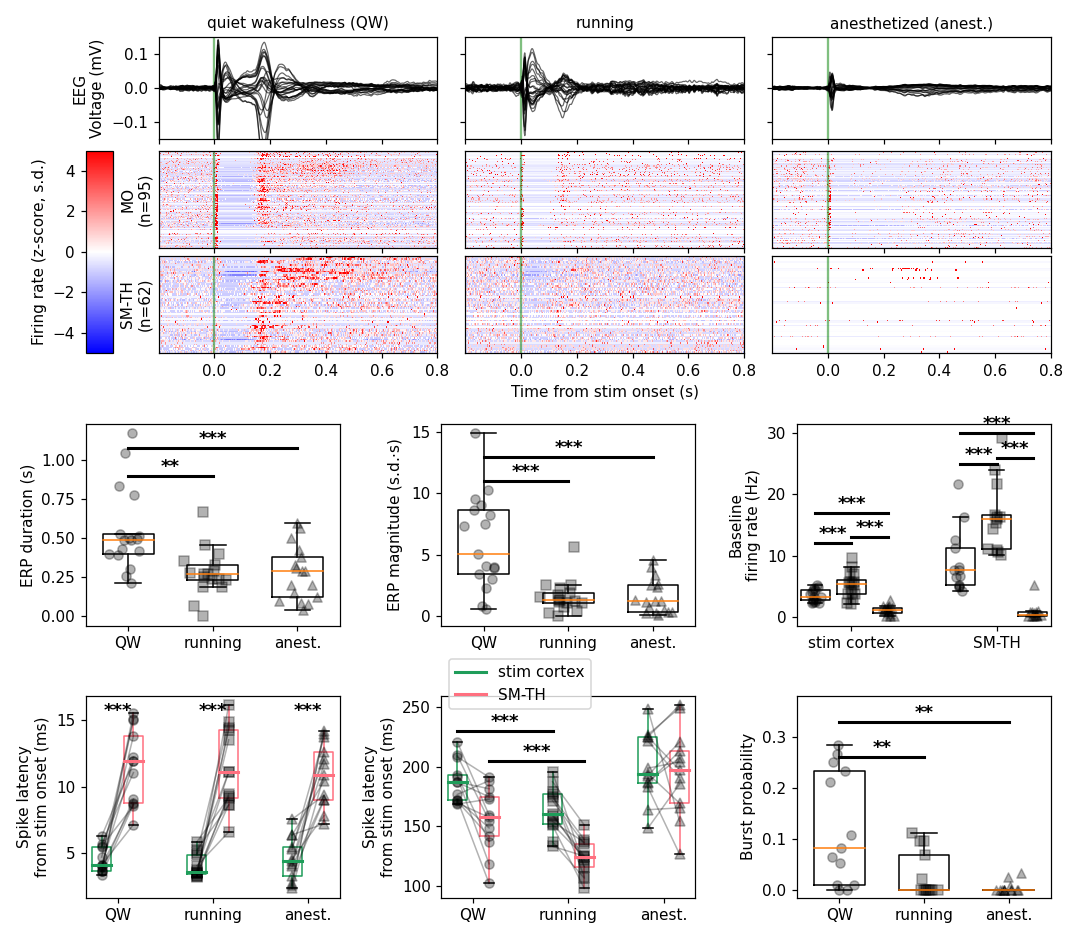

In [70]:
## Original for manuscript, shapes ##
plot_stim = 'medium'
exgroup = 'MOs_deep'
plot_regions = {'stim_cortex': [True, area_colors['MO']], 'region': ['MO-TH', area_colors['MO-TH']]}
plwin = [-0.2, 0.8]
eeg_ylim = [-0.15, 0.15]
vlevel = 1
Zlim = 5
plot_depth = 'deep'

all_states = list(example_EEG_traces[exgroup][plot_stim].keys())
locs1 = np.arange((len(plot_regions) + 1) * len(all_states)).reshape((len(all_states), (len(plot_regions) + 1)))
locs2 = np.arange(len(plot_regions) * (len(all_states) + 1)).reshape((len(plot_regions), (len(all_states) + 1)))

fig = plt.figure(figsize=(9.75, 8.5))
gs = fig.add_gridspec(ncols=1, nrows=2, left=0.08, right=0.98, top=0.96, bottom=0.04, height_ratios=[2, 3], hspace=0.18)
ggs = gs[0].subgridspec(ncols=2, nrows=2, height_ratios=[1, 2], width_ratios=[0.03, 1], wspace=0.1, hspace=0.08)
EEGaxs = ggs[0,1].subgridspec(ncols=len(all_states), nrows=1, wspace=0.1).subplots(sharex=True, sharey=True)
NPXaxs = ggs[1,1].subgridspec(ncols=len(all_states), nrows=2, hspace=0.08, wspace=0.1).subplots(sharex=True)
METaxs = gs[1].subgridspec(ncols=3, nrows=2, hspace=0.35, wspace=0.4).subplots()

for coli, statei in enumerate(all_states):
    stsh = stshapes[statei]
    EEG_traces = example_EEG_traces[exgroup][plot_stim][statei]
    GOOD_CHS = multi_sub_dict[exgroup][example_mice[exgroup]]['good_chs']
    unitZ = example_unit_zscore[exgroup][plot_stim][statei]
    
    ## Plot EEG traces ##
    EEGaxs[coli].axvline(0, color='g', alpha=0.5)
    EEGaxs[coli].plot(EEG_traces[0], np.mean(EEG_traces[1][:, GOOD_CHS, :], axis=2) / 1E3, 'k', linewidth=0.8, alpha=0.6)
    EEGaxs[coli].set_xlim(plwin)
    EEGaxs[coli].set_xticklabels([])
    EEGaxs[coli].set_ylim(eeg_ylim)
    if coli == 0:
        EEGaxs[coli].set_ylabel('EEG\nVoltage (mV)')
    
    ## Plot unit z-score activity ##
    for kk, (region, zscores) in enumerate(unitZ.items()):
        imunit = NPXaxs[kk, coli].imshow(
            zscores[1].T, cmap='bwr', interpolation='none', aspect='auto', origin='upper', vmin=-Zlim, vmax=Zlim,
            extent=[zscores[0][0], zscores[0][-1], 0, zscores[1].shape[1]],
        )
        NPXaxs[kk, coli].set_xlim(plwin)
        NPXaxs[kk, coli].axvline(0, color='g', alpha=0.5)
        NPXaxs[kk, coli].set_yticks([])    
            
    ## Plot EEG magnitude and duration ##
    EEGmetrics = all_subs_EEG_stats_df[
        (all_subs_EEG_stats_df['stim_depth'] == plot_depth) &
        (all_subs_EEG_stats_df['stim_level'] == plot_stim) &
        (all_subs_EEG_stats_df['state'] == statei)
    ]
    xs = np.random.normal(coli, 0.1, len(EEGmetrics))
    METaxs[0,0].boxplot(EEGmetrics['duration'].values, positions=[coli], widths=[0.6], showfliers=False)
    METaxs[0,0].scatter(xs, EEGmetrics['duration'].values, c='k', marker=stsh, alpha=0.3)
    METaxs[0,1].boxplot(EEGmetrics['magnitude'].values, positions=[coli], widths=[0.6], showfliers=False)
    METaxs[0,1].scatter(xs, EEGmetrics['magnitude'].values, c='k', marker=stsh, alpha=0.3)
    
    ## Plot unit metrics ##
    early_lats = []
    late_lats = []
    for jj, (categ, spec) in enumerate(plot_regions.items()):
        unitdf = all_subs_unit_stats_df[
            (all_subs_unit_stats_df['stim_level'] == plot_stim) & (all_subs_unit_stats_df['stim_depth'] == plot_depth) &
            (all_subs_unit_stats_df['state'] == statei) & (all_subs_unit_stats_df[categ] == spec[0])
        ]
        xloc = locs2[jj, coli]
        xxs = np.random.normal(xloc, 0.1, len(unitdf))
        ## Baseline firing rate ##
        METaxs[0,2].boxplot(unitdf['baselineFR'].values, positions=[xloc], widths=[0.8], showfliers=False)
        METaxs[0,2].scatter(xxs, unitdf['baselineFR'].values, c='k', marker=stsh, alpha=0.3)
        
        temp_early = unitdf['early_latency'][unitdf['ctx_and_th'] == True].values * 1E3
        temp_late = unitdf['late_latency'][unitdf['ctx_and_th'] == True].values * 1E3
        METaxs[1,0].boxplot(temp_early, positions=[locs1[coli, jj]], widths=[0.6], showfliers=False,
            medianprops={'color': spec[1], 'linewidth': 2}, boxprops={'color': spec[1]}, whiskerprops={'color': spec[1]})
        METaxs[1,1].boxplot(temp_late, positions=[locs1[coli, jj]], widths=[0.6], showfliers=False,
            medianprops={'color': spec[1], 'linewidth': 2}, boxprops={'color': spec[1]}, whiskerprops={'color': spec[1]})
        early_lats.append(temp_early)
        late_lats.append(temp_late)
    
    ## Plot latencies, early and late ##
    xpos = locs1[coli, :-1]
    METaxs[1,0].plot(xpos, np.stack(early_lats), 'k', linewidth=1.0, marker=stsh, alpha=0.3)
    METaxs[1,1].plot(xpos, np.stack(late_lats), 'k', linewidth=1.0, marker=stsh, alpha=0.3)
    
    ## Plot burst probability ##
    THdf = all_subs_unit_stats_df[
        (all_subs_unit_stats_df['stim_level'] == plot_stim) & (all_subs_unit_stats_df['stim_depth'] == plot_depth) &
        (all_subs_unit_stats_df['state'] == statei) & (all_subs_unit_stats_df['region'] == 'MO-TH')
    ]
    xxxs = np.random.normal(coli, 0.1, len(THdf))
    METaxs[1,2].boxplot(THdf['burst_prob'].values, positions=[coli], widths=[0.6], showfliers=False)
    METaxs[1,2].scatter(xxxs, THdf['burst_prob'].values, c='k', marker=stsh, alpha=0.3)
        
## Add labels ##
new_st_labels = ['QW', 'running', 'anest.']
METaxs[0,0].set_ylabel('ERP duration (s)')
METaxs[0,0].set_xticklabels(new_st_labels)
METaxs[0,1].set_ylabel('ERP magnitude (s.d.$\cdot$s)')
METaxs[0,1].set_xticklabels(new_st_labels)
METaxs[0,2].set_ylabel('Baseline\nfiring rate (Hz)')
METaxs[0,2].set_xticks(np.mean(locs2[:,:-1], axis=1))
METaxs[0,2].set_xticklabels(['stim cortex', 'SM-TH'])
METaxs[1,0].set_ylabel('Spike latency\nfrom stim onset (ms)')
METaxs[1,1].set_ylabel('Spike latency\nfrom stim onset (ms)')
METaxs[1,0].set_xticks(np.mean(locs1[:,:-1], axis=1))
METaxs[1,0].set_xticklabels(new_st_labels)
METaxs[1,1].set_xticks(np.mean(locs1[:,:-1], axis=1))
METaxs[1,1].set_xticklabels(new_st_labels)
METaxs[1,2].set_ylabel('Burst probability')
METaxs[1,2].set_xticklabels(new_st_labels)

NPXaxs[1,1].set_xlabel('Time from stim onset (s)')
NPXaxs[0,0].set_ylabel('MO\n(n=95)')
NPXaxs[1,0].set_ylabel('SM-TH\n(n=62)')

EEGaxs[0].set_title('quiet wakefulness (QW)')
EEGaxs[1].set_title('running')
EEGaxs[2].set_title('anesthetized (anest.)')

NPXaxs[1,0].set_xticks(NPXaxs[1,0].get_xticks()[1:])
# NPXaxs[1,0].set_xticklabels(NPXaxs[1,0].get_xticks()[1:])
            
## Add the colorbar ##
ucbax = fig.add_subplot(ggs[1,0])
ucb = Colorbar(ax=ucbax, mappable=imunit, orientation='vertical', ticklocation='left')
ucb.set_label('Firing rate (z-score, s.d.)')

## Stats annotation ##
# Duration #
METaxs[0,0].plot([0,1], [0.9,0.9], color='k', linewidth=2)
METaxs[0,0].annotate('**', xy=(0.5,0.9), xycoords='data', fontsize=12, fontweight='bold', ha='center', va='bottom')
METaxs[0,0].plot([0,2], [1.08,1.08], color='k', linewidth=2)
METaxs[0,0].annotate('***', xy=(1,1.08), xycoords='data', fontsize=12, fontweight='bold', ha='center', va='bottom')
# Magnitude #
METaxs[0,1].plot([0,1], [11,11], color='k', linewidth=2)
METaxs[0,1].annotate('***', xy=(0.5,11), xycoords='data', fontsize=12, fontweight='bold', ha='center', va='bottom')
METaxs[0,1].plot([0,2], [13,13], color='k', linewidth=2)
METaxs[0,1].annotate('***', xy=(1,13), xycoords='data', fontsize=12, fontweight='bold', ha='center', va='bottom')
# BL FR #
METaxs[0,2].plot([0,1], [12,12], color='k', linewidth=2)
METaxs[0,2].annotate('***', xy=(0.5,12), xycoords='data', fontsize=12, fontweight='bold', ha='center', va='bottom')
METaxs[0,2].plot([1,2], [13,13], color='k', linewidth=2)
METaxs[0,2].annotate('***', xy=(1.5,13), xycoords='data', fontsize=12, fontweight='bold', ha='center', va='bottom')
METaxs[0,2].plot([0,2], [17,17], color='k', linewidth=2)
METaxs[0,2].annotate('***', xy=(1,17), xycoords='data', fontsize=12, fontweight='bold', ha='center', va='bottom')
METaxs[0,2].plot([4,5], [25,25], color='k', linewidth=2)
METaxs[0,2].annotate('***', xy=(4.5,25), xycoords='data', fontsize=12, fontweight='bold', ha='center', va='bottom')
METaxs[0,2].plot([5,6], [26,26], color='k', linewidth=2)
METaxs[0,2].annotate('***', xy=(5.5,26), xycoords='data', fontsize=12, fontweight='bold', ha='center', va='bottom')
METaxs[0,2].plot([4,6], [30,30], color='k', linewidth=2)
METaxs[0,2].annotate('***', xy=(5,30), xycoords='data', fontsize=12, fontweight='bold', ha='center', va='bottom')
# Early latency #
METaxs[1,0].annotate('***', xy=(0.5,15), xycoords='data', fontsize=12, fontweight='bold', ha='center', va='bottom')
METaxs[1,0].annotate('***', xy=(3.5,15), xycoords='data', fontsize=12, fontweight='bold', ha='center', va='bottom')
METaxs[1,0].annotate('***', xy=(6.5,15), xycoords='data', fontsize=12, fontweight='bold', ha='center', va='bottom')
# Late latency #
METaxs[1,1].plot([0,3], [230,230], color='k', linewidth=2)
METaxs[1,1].annotate('***', xy=(1.5,230), xycoords='data', fontsize=12, fontweight='bold', ha='center', va='bottom')
METaxs[1,1].plot([1,4], [205,205], color='k', linewidth=2)
METaxs[1,1].annotate('***', xy=(2.5,205), xycoords='data', fontsize=12, fontweight='bold', ha='center', va='bottom')
# Burst probability #
METaxs[1,2].set_ylim([-0.015,0.38])
METaxs[1,2].plot([0,1], [0.26,0.26], color='k', linewidth=2)
METaxs[1,2].annotate('**', xy=(0.5,0.26), xycoords='data', fontsize=12, fontweight='bold', ha='center', va='bottom')
METaxs[1,2].plot([0,2], [0.33,0.33], color='k', linewidth=2)
METaxs[1,2].annotate('**', xy=(1,0.33), xycoords='data', fontsize=12, fontweight='bold', ha='center', va='bottom')

## Legend ##
leghandles = [
    Line2D([0], [0], c=area_colors['MO'], linewidth=2, label='stim cortex'),
    Line2D([0], [0], c=area_colors['MO-TH'], linewidth=2, label='SM-TH'),
]
METaxs[1,1].legend(handles=leghandles, bbox_to_anchor=(0, 0.9), loc='lower left')

## Save ##
figname = 'Fig7_{}.png'.format(date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=300)

## Save as .pdf for Illustrator ##
# fig.savefig(os.path.join(plotsdir, 'AI_pdfs', figname.replace('.png', '.pdf')), transparent=True, dpi=300)

## Plots for GRC poster

Plot EEG and units examples

Plot EEG metrics

Plot unit metrics

# Make individual plots for IR

### Plot metrics for resting vs. running

#### Plot EEG ERP magnitude in specified window

#### Plot EEG ERP duration

#### Plot baseline firing rate

STIM CORTEX vs MO-TH only

ALL REGIONS

#### Plot burst probability in specified window

All normality tests